# Fig. 8
It loads and transform the result of correlation generated by the script `correlation.py`. Cavity and simulations are compared

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from collections import Counter
import random
import pickle
import re
import pandas as pd
from os import listdir
from collections import defaultdict 
import os
import sys
sys.path.insert(0, "../lib")  # add the library folder to the path I look for modules
import latexify

%matplotlib inline

$$C_{ij}= \left\langle\tanh\left(\frac{\beta}{2}h_i\right)\tanh\left(\frac{\beta}{2}h_j\right) \right\rangle_{\mathbf{n}\partial_i\mathbf{n}\partial_j}$$

In [3]:
dir_list = next(os.walk('.'))[1]# select only first subdirectories
folder_pattern = re.compile("kin=[0-9]+")
folder_names=[name  for name in dir_list if folder_pattern.match(name)]# select only folder with specific names
pattern2 = re.compile("\d+.\d+|\d+")
matching_folders=[[n for n in pattern2.findall(folder)] for folder in folder_names]
print("Select one of this folder\ngamma")
for el in matching_folders:
    print(str(el[0]))

Select one of this folder
gamma
2
4
3


In [4]:
kin = 2
def load_obj(folder,name ):
    with open(folder+'/data/dic-' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def load_and_hist(T,kin,**kwargs):
    dic=load_obj('kin:'+str(kin),"T:"+str(T))
    N=dic["N"]
    kin=dic["kin"]
    T=dic["T"]
    J=dic["J"]    
    P_sim=dic["P_sim"]
    C_sim=dic["C_sim"]
    P_cav=dic["P_cav"]
    C_cav=dic["C_cav"]
    h_dyn,b_dyn=histogram(P_sim,**kwargs,density=True)
    h_cavity,b_cavity=histogram(P_cavity,bins=b_dyn,density=True)
    #plot(bins[:-1],h_cavity,"-",mfc="w",label="cavity"+str(T))
    return b_dyn,h_dyn,h_cavity
folder="kin="+str(kin)
filenames=listdir(folder+"/data")
pattern = re.compile("dic-T=\d*\.\d+|\d+.pkl")
dictnames=[name  for name in filenames if pattern.match(name)]# select only dictionary files
pattern2 = re.compile("\d*\.\d+|\d+")
sim_params=[[n for n in pattern2.findall(dic)] for dic in dictnames]
print("Simulation available for")
for el in sim_params:
    print(el[0])

def triu_todense(data,N):
    A= np.zeros((N,N))
    i,j = np.triu_indices(N,k=1)
    A[i,j]=data
    np.fill_diagonal(A,1)
    return A

Simulation available for
0.2
0.4


Load data

In [5]:
T = 0.4
dic=load_obj(folder,"T="+str(T))
N=dic["N"]
kin=dic["kin"]
T=dic["T"]
J=dic["J"]    
P_sim=dic["P_sim"]
C_sim=dic["C_sim"]
P_cav=dic["P_cav"]
C_cav=dic["C_cav"]
new_C_cav = dic['new_C_cav']
m = 2*P_cav-1
C_sim = triu_todense(C_sim,N)
C_cav = triu_todense(C_cav,N)
new_C_cav = triu_todense(new_C_cav,N)
cov_cav = (C_cav-np.outer(m,m))/np.sqrt(np.outer(1-m**2,1-m**2))
cov_cav_new = (new_C_cav-np.outer(m,m))/np.sqrt(np.outer(1-m**2,1-m**2))
cov_sim = (C_sim-np.outer(2*P_sim-1,2*P_sim-1))/np.sqrt(np.outer(4*P_sim*(1-P_sim),4*P_sim*(1-P_sim)))
cov_sim[np.isnan(cov_sim)]=0
cov_sim[np.isinf(cov_sim)]=0
np.fill_diagonal(cov_sim,1)
print('N',N,'N. replics:',dic['N_replics'],'N iterations',dic['N_iterations'])

    

N 5000 N. replics: 10 N iterations 30000


T= 0.4


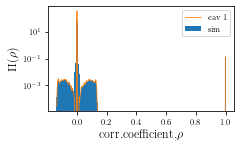

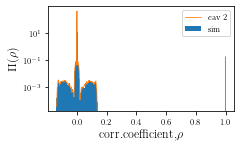

In [6]:
latexify.latexify(columns = 2)

h,b,_ = plt.hist(cov_sim[np.triu_indices(N)],400,density=True,label = 'sim')
h,b = np.histogram(cov_cav[np.triu_indices(N)],b,density=True)
plt.plot((b[1:]+b[:-1])/2,h,label = 'cav 1',alpha = 1,lw = 0.8)
plt.semilogy()
plt.legend()
plt.xlabel('corr.coefficient,$\\rho$',fontsize= 12)
plt.ylabel('$\Pi(\\rho)$',fontsize= 12)
plt.tight_layout()
#plt.savefig('corr_coeff.pdf')
plt.figure()
h,b,_ = plt.hist(cov_sim[np.triu_indices(N)],500,density=True,label = 'sim')
h,b = np.histogram(cov_cav_new[np.triu_indices(N)],b,density=True)
plt.plot((b[1:]+b[:-1])/2,h,label = 'cav 2',alpha = 1,lw = 0.8)
plt.semilogy()
plt.legend()
plt.xlabel('corr.coefficient,$\\rho$',fontsize= 12)
plt.ylabel('$\Pi(\\rho)$',fontsize= 12)
plt.tight_layout()
print('T=',T)
#plt.savefig('corr_coeff_corrected.pdf')

## Quantify accuracy
Let me call $Y = |C_{cav}-C_{sim}|$. The matrix investigates the different values returned by
Cavity and simulation for the correlation 

In [15]:
Y = np.triu(np.abs(cov_cav_new-cov_sim))
i,j = np.where(np.abs(Y)>1e-2)
i,j,_ = zip(*sorted(zip(i,j,np.abs(Y)[np.abs(Y)>1e-2]),key =lambda x:x[2],reverse=True) )

Text(0, 0.5, '$\\mathrm{Prob}$(err$<\\epsilon$)')

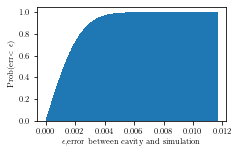

In [16]:
h,b = np.histogram(Y[np.triu_indices(N,k=1)],bins = 1000)
plt.bar(b[:-1],np.cumsum(h)/(N*(N-1)/2),np.diff(b))
plt.xlabel('$\epsilon$,error between cavity and simulation')
plt.ylabel('$\mathrm{Prob}$(err$<\epsilon$)')
